# Imputation testing code

### Before running code you must have :
 
 * train.csv in same directory.
 * python 3 installed
 * libraries used in code installed.
 
**Importing the libraries that will be used**

In [3]:
import pandas as pd
import numpy as np
import sys as sys

# for fitting a decision tree
from sklearn.tree import DecisionTreeRegressor

# this import an renaming is needed to import missforest
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
# Importing the library from python to impute the missing values with MissForest tactic.
from missingpy import MissForest
# Import the KNNImputer
from sklearn.impute import KNNImputer
# Import simpleimputer to import with median
from sklearn.impute import SimpleImputer

# Can create a confusion matrix with accuracy to see how good model is.
from sklearn import metrics
# Importing accuracy_score to auto calculate our classifiers accuracy
from sklearn.metrics import accuracy_score

# Importing so we can create confusion matrix images.
import matplotlib.pyplot as plt
import seaborn as sn

# Imports for reproducible code and time-handling.
import random
import time

**Reading the train.csv in the code to use**

In [23]:
original_df = pd.read_csv("train.csv") 
original_df.head(5)

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 262799 to 299908
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      60000 non-null  int64  
 1   cat0    60000 non-null  object 
 2   cat1    60000 non-null  object 
 3   cat2    60000 non-null  object 
 4   cat3    60000 non-null  object 
 5   cat4    60000 non-null  object 
 6   cat5    60000 non-null  object 
 7   cat6    60000 non-null  object 
 8   cat7    60000 non-null  object 
 9   cat8    60000 non-null  object 
 10  cat9    60000 non-null  object 
 11  cat10   60000 non-null  object 
 12  cat11   60000 non-null  object 
 13  cat12   60000 non-null  object 
 14  cat13   60000 non-null  object 
 15  cat14   60000 non-null  object 
 16  cat15   60000 non-null  object 
 17  cat16   60000 non-null  object 
 18  cat17   60000 non-null  object 
 19  cat18   60000 non-null  object 
 20  cont0   60000 non-null  float64
 21  cont1   60000 non-null  float

### Choosing columns to apply imputation techniques

We have a data frame that consists with 32 columns and 300K rows, 
- Here we use only 3 columns cont0, cont1 and cont2 just for testing illustrations for now.

In [16]:
# Separating and isolating the respond value from the rest dataset.
true_values = original_df[['target']].copy()

# Keeping columns interested.
imputation_data = original_df[['cat1','cont0','cont1', 'cont2', 'target']].copy()
# Keep original columns to compare with the imputed values.
original_used_data = imputation_data.copy()
imputation_data.head(3)

,cat1,cont0,cont1,cont2,target
0,I,0.629858,0.855349,0.759439,0
1,I,0.370727,0.328929,0.386385,0
2,K,0.502272,0.322749,0.343255,0


In [17]:
# Divide predictors from respond.
imputation_predictors = imputation_data[['cat1', 'cont0', 'cont1', 'cont2']].copy()
imputation_respond = imputation_data[['target']].copy()
imputation_predictors.head(5)

,cat1,cont0,cont1,cont2
0,I,0.629858,0.855349,0.759439
1,I,0.370727,0.328929,0.386385
2,K,0.502272,0.322749,0.343255
3,K,0.934242,0.707663,0.831147
4,I,0.254427,0.274514,0.338818


In [18]:
imputation_respond.head(5)

,target
0,0
1,0
2,0
3,0
4,1


In [19]:
### Fit a model to predict target using cont 2 with all the true values.

# Initializing random-state for repsoducible reason.
tree_reg = DecisionTreeRegressor(random_state=96)
# Fitting a Decision Tree
tree_reg.fit(imputation_predictors, imputation_respond)

ValueError: could not convert string to float: 'I'

In [9]:
# Making predictions with same data used to train model.
predicted = tree_reg.predict(imputation_predictors)
print("True values: ", imputation_respond.values[0:10])
print("Predicted values: ", predicted[0:10])

True values:  [[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]]
Predicted values:  [0. 0. 0. 0. 1. 0. 0. 1. 0. 1.]


In [10]:
# Can create a confusion matrix with accuracy to see how good model is.
print(metrics.confusion_matrix(imputation_respond, predicted))

[[220539      0]
 [     0  79461]]


We see a PERFECT accuracy prediction. Most likely is overfitting because memorising the data.

## Randomly Removing the values and making them null

In [11]:
len(imputation_predictors)*20/100

60000.0

In [12]:
# funtion the will remove values from column cont1 at random
# replace the removed values with NaN which is null.
def remove_random_values(df):
    # Set seed for reproducible reasons. Achieving same modified set every run.
    random.seed(5059)
    
    # Getting 20% of the data sample to remove values.
    put_missing_values = df.sample(
        int(len(df)*20/100))
    
    # Replacing all values with string nan because we cannot update data frame IF
    # values are null. Python will keep old values in the update.
    put_missing_values['cont0'] = 'nan'
    
    # Update data frame with new 'nan' values
    df.update(put_missing_values)

    # Replacing the 'nan' values to real nan values.
    df = df.replace('nan', np.nan)
    
    return df

In [13]:
# function that will create confusion matrix plot.
# Coded in function for less clatter in latter code and more reproducible.
def plot_confusion_matrix(cm):
    data_for_confusion = pd.DataFrame(cm,
                                  index = [["0", "1"]],
                                  columns = [["0", "1"]])
    plt.figure(figsize = (10,7))
    confusion_matrix = sn.heatmap(data_for_confusion,
                              annot=True, 
                              fmt='d', annot_kws={"size": 16},
                              cbar=False)

    plt.xlabel("Predicted Values") 
    plt.ylabel("True Values") 
    plt.show()

In [14]:
# Calling function to remove randome values and replacing them with null.
# Same exact set will be used across all datasets.
ready_for_imputation = remove_random_values(imputation_predictors.copy())
ready_for_imputation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cont0   240000 non-null  float64
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
dtypes: float64(3)
memory usage: 6.9 MB


From the above results we see we have 60 000 values as null in column 'cont0'

## Imputing with median value.

In [13]:
# Copying set to impute with median
median_imputation = ready_for_imputation.copy()
median_imputation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cont0   240000 non-null  float64
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
dtypes: float64(3)
memory usage: 6.9 MB


In [14]:
# Imputing with 'median' strategy on data.
median_imputer = SimpleImputer(strategy="median")
median_imputer.fit(median_imputation)
# Once the data has been impute is outputs in an array
RawOutput = median_imputer.transform(median_imputation)

# We want to convert the array back to data frame now for further computations.
median_imputation = pd.DataFrame(RawOutput, 
                                 columns = median_imputation.columns,
                                 index = median_imputation.index)

median_imputation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cont0   300000 non-null  float64
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
dtypes: float64(3)
memory usage: 6.9 MB


In [15]:
# Making predictions with same data used to train model.
predicted_median = tree_reg.predict(median_imputation)
print("True values: ", imputation_respond.values[0:10])
print("Predicted values: ", predicted_median[0:10])

True values:  [[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]]
Predicted values:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]


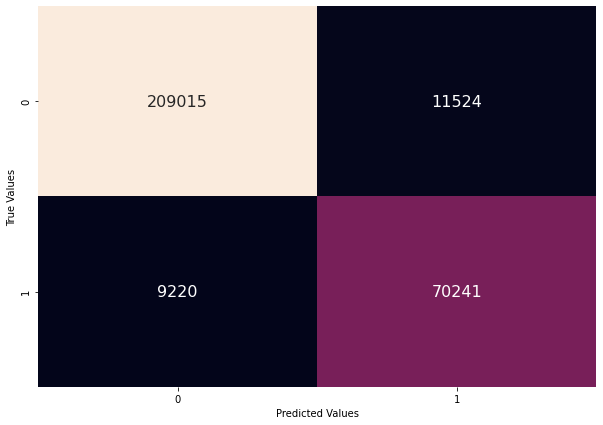

In [16]:
# Can create a confusion matrix with accuracy to see how good model is.
# Calling function to create the confusion matrix and plot
plot_confusion_matrix(metrics.confusion_matrix(imputation_respond, predicted_median))

In [17]:
print("When imputing using the simple 'median' imputer we get : ", 
      accuracy_score(imputation_respond, predicted_median, normalize=True),
     "accuracy score")

When imputing using the simple 'median' imputer we get :  0.9308533333333333 accuracy score


## Imputing with MissForest

imputing tactic found on youtube [press here to view](https://www.youtube.com/watch?v=WhUm9jCoYf4) and website ecplaining in text [press here](https://www.betterdatascience.com/python-missforest/)

- We can write about it towards the end. We have the material here.

In [32]:
# Getting the data frame with missing values to impute.
miss_forest_data = ready_for_imputation.copy()
miss_forest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cont0   240000 non-null  float64
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
dtypes: float64(3)
memory usage: 6.9 MB


In [33]:
# Create imputation tactic.
miss_forest_imputer = MissForest()

In [34]:
%%time
# Once the data has been impute is outputs in an array
RawOutput = miss_forest_imputer.fit_transform(miss_forest_data)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
CPU times: user 10min 30s, sys: 13.1 s, total: 10min 43s
Wall time: 3min 9s


In [35]:
# We want to convert the array back to data frame now for further computations.
miss_forest_data = pd.DataFrame(RawOutput, 
                                 columns = miss_forest_data.columns,
                                 index = miss_forest_data.index)

miss_forest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cont0   300000 non-null  float64
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
dtypes: float64(3)
memory usage: 6.9 MB


In [36]:
# Making predictions with same data used to train model.
predicted_missforest = tree_reg.predict(miss_forest_data)
print("True values: ", imputation_respond.values[0:10])
print("Predicted values: ", predicted_missforest[0:10])

True values:  [[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]]
Predicted values:  [0. 0. 0. 0. 1. 0. 0. 1. 0. 1.]


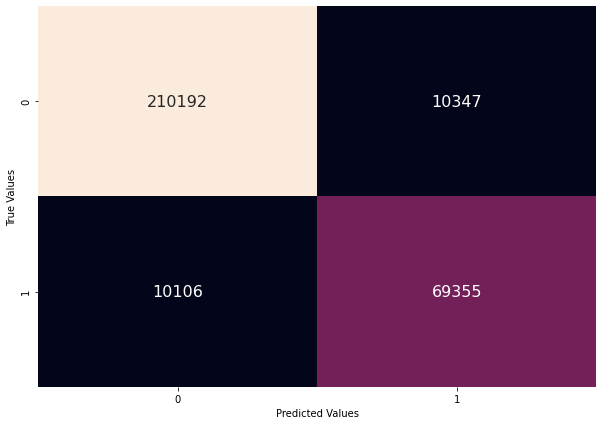

In [37]:
# Can create a confusion matrix with accuracy to see how good model is.
# Calling function to create the confusion matrix and plot
plot_confusion_matrix(metrics.confusion_matrix(imputation_respond, predicted_missforest))

In [38]:
print("When imputing using the simple 'median' imputer we get : ", 
      accuracy_score(imputation_respond, predicted_missforest, normalize=True),
     "accuracy score")

When imputing using the simple 'median' imputer we get :  0.9318233333333333 accuracy score


## Impute with KNNImputer

- We can research a bit more on the algorithm, for now we testing them to see how they work. I found this from : [press here](https://towardsdatascience.com/missing-value-imputation-with-python-and-k-nearest-neighbors-308e7abd273d)

In [39]:
# Getting the data frame with missing values to impute.
knn_imputer_data = ready_for_imputation.copy()
knn_imputer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cont0   240000 non-null  float64
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
dtypes: float64(3)
memory usage: 6.9 MB


In [40]:
# We can adjust hyperparameter n_neighbors.
knn_imputer = KNNImputer(n_neighbors=3)

In [41]:
%%time
# Imputing values
RawOutput = knn_imputer.fit_transform(knn_imputer_data)

CPU times: user 16min 43s, sys: 4min 36s, total: 21min 19s
Wall time: 19min 20s


In [42]:
# We want to convert the array back to data frame now for further computations.
knn_imputer_data = pd.DataFrame(RawOutput, 
                                 columns = knn_imputer_data.columns,
                                 index = knn_imputer_data.index)

knn_imputer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cont0   300000 non-null  float64
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
dtypes: float64(3)
memory usage: 6.9 MB


In [43]:
# Making predictions with same data used to train model.
predicted_knn = tree_reg.predict(knn_imputer_data)
print("True values: ", imputation_respond.values[0:10])
print("Predicted values: ", predicted_knn[0:10])

True values:  [[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]]
Predicted values:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]


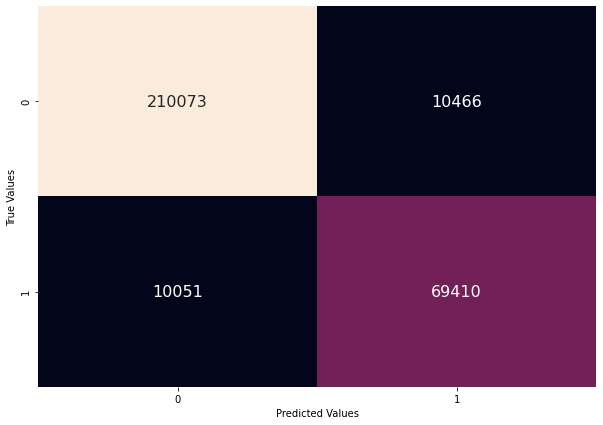

In [44]:
# Can create a confusion matrix with accuracy to see how good model is.
# Calling function to create the confusion matrix and plot
plot_confusion_matrix(metrics.confusion_matrix(imputation_respond, predicted_knn))

In [45]:
print("When imputing using the simple 'median' imputer we get : ", 
      accuracy_score(imputation_respond, predicted_knn, normalize=True),
     "accuracy score")

When imputing using the simple 'median' imputer we get :  0.93161 accuracy score


From the accuracy scores we obtained, we conclude the best imputation method is the MissForest one. => However how do we kno it was not only by luck? Only good for the specific imputation set?
 - We need further investgation to explore on this. Maybe k-fold CV but knn takes too long to input it in a cross validation..
 

In [ ]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
### IMPORT LIBRARIES

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys as sys

# for fitting a decision tree
from sklearn.tree import DecisionTreeRegressor

# this import an renaming is needed to import missforest
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
# Importing the library from python to impute the missing values with MissForest tactic.
from missingpy import MissForest
# Import the KNNImputer
from sklearn.impute import KNNImputer
# Import simpleimputer to import with median
from sklearn.impute import SimpleImputer

# Can create a confusion matrix with accuracy to see how good model is.
from sklearn import metrics
# Importing accuracy_score to auto calculate our classifiers accuracy
from sklearn.metrics import accuracy_score

# Importing so we can create confusion matrix images.
import matplotlib.pyplot as plt
import seaborn as sn

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Set seed for reproducible reasons. Achieving same modified set every run.
# todo: check if the same seed works from python to R, hence avoid storing data and just running same analysis on R.

import random
import time
# random.seed(5059)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
### IMPORT DATA

original_df = pd.read_csv("train.csv")
original_df.head(6)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
### FUNCTION TO REMOVE DATA

def remove_random_values(df, columns, percentage):
    """
    Funtion the will remove values from the selected columns at random,
    then replace the removed values with np.nan which is NaN.

    PSEUDOCODE:

    1. Random sample row indexes (with replacement)
    2. Random sample column labels (with replacement)
    3. Extract random entry and replace with np.nan
    4. Repeat (1-3) until total proportion of data has been extracted

    :param df: pandas DataFrame
    :param columns: list of columns to 'drop' values from. Note: must be string name of columns
    :param percentage: float input such as 0.20 (i.e. 20%)
    :return: DataFrame with NaN entries
    """

    start = time.time()
    # Set up: Focus on subset of data dependent on columns,
    #         hence extract information about subset and number of values to drop
    # df = df.copy()
    subset = df[columns].copy()
    nrow, ncol = subset.shape
    n_samples = int(percentage*nrow)

    # 1. Pick out a vector of random samples (row indexes)
    row_indexes = np.arange(0, nrow, 1).tolist()

    # 2. Sample with replacement from the list of possible indexes
    #    note, `choices` is used to sample with replacement
    sampled_row_indexes = random.choices(row_indexes, k = n_samples)
    sampled_columns = random.choices(columns, k = n_samples)

    # true_value = []
    # 3. Replace all entries with NaN
    
    for i in range(0, n_samples):
        # true_value.append([subset.loc[sampled_row_indexes[i], sampled_columns[i]], sampled_row_indexes[i], sampled_columns[i]])
        
        ################
        # MODIFIED
        # The problem with time was we changing the float cell to string explicitily but the column was of 
        # type float. (I think this was the issue). Now i basically put null
        # then replace null to 'nan' -> update -> replace 'nan' to null
        # IT IS VERY stupid and repeating tasks but it seems to do the trick.
        # I also checked final data frame structure and the data types are correct
        #  with correct null values (you can double check tho)

        subset.loc[sampled_row_indexes[i], sampled_columns[i]] = np.nan

    print("11111111111111111111111111111111111111111111")
    # Replacing the null to 'nan' so we can update.
    subset = subset.fillna(value=np.nan)
    subset = subset.replace(np.nan,'nan')
    print("2222222222222222222222222222222222222222222222222")
    # MODIFY END
    ######################

    # note having it as a loop ensures we are not holding a massive dataframe in memory so its a lot faster.
    # e.g. the vectorised version subset.loc[sampled_row_indexes, sampled_columns] = np.nan is too expensive

    # 4. Update data frame with new NaN values
    df.update(subset)
    # replacing 'nan' in whole dataframe back to null
    df = df.replace('nan', np.nan)

    end = time.time()
    print("Time Elapsed : ", end - start)
    
    df.info()

    return(df)

### Sample runs using the entire dataset:

########################
# MODIFIED
# you had all 3 method calls in value df -> you were replacing the old df with new df
# every time so in the end we only had saved the one scenario
# dont know if this was done on purpose or by mistake.

# discrete only case
df_cat = remove_random_values(original_df.copy(), ['cat0', 'cat1'], 0.2)
# Time Elapsed : 4.55 seconds

# continuous only case
df_cont = remove_random_values(original_df.copy(), ['cont0', 'cont1'], 0.2)
# Time Elapsed : 250.5184588432312/60 = 4 minutes ??

# both discrete and continuous cases
df_both = remove_random_values(original_df.copy(), ['cat1', 'cont2'], 0.2)
# Time Elapsed : 96.34 seconds ( why so long? )
# Bizzare

# Time fixed (i think ahaha)
# MODIFIED DONE
###########################

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
### FUNCTION TO RUN MODELS

# todo: this only currently works for continuous features - none of the methods support categorical features
#       need to look into setting up a pipeline which supports both.
#       Look into `FeatureUnion` it is sort of like a Pipeline thing but suitable for imputations.

def imputation_methods(df, complete_df, columns):
    """
    Function which runs through our chosen three methods: Median Imputation, MissForest and KNNImputer.

    :param df: dataframe which has missing data - subset on the columns to impute only
    :param complete_df: dataframe which has the complete data
    :param columns: list of columns strings used in the remove_random_values() function.
    :return: the three imputed datasets (for now)
    """

    start = time.time()

    ##### DEPLOY METHODS:

    ### STRATEGY 1: MEDIAN IMPUTATION

    # Impute Data
    median_imputation = df.copy()
    median_imputer = SimpleImputer(strategy = "median")
    median_imputer.fit(median_imputation)

    # Once the data has been impute is outputs in an array
    RawOutput = median_imputer.transform(median_imputation)

    # We want to convert the array back to data frame now for further computations.
    median_imputation_data = pd.DataFrame(RawOutput,
                                     columns = median_imputation.columns,
                                     index = median_imputation.index)

    del median_imputation
    del RawOutput

    middle1 = time.time()

    print("Median Imputation Complete - Time Elapsed :", middle1 - start)

    ### STRATEGY 2: MissForest

    miss_forest_data = df.copy()

    # Create imputation tactic.
    miss_forest_imputer = MissForest()
    # Once the data has been impute is outputs in an array
    RawOutput = miss_forest_imputer.fit_transform(miss_forest_data)

    # We want to convert the array back to data frame now for further computations.
    miss_forest_data = pd.DataFrame(RawOutput,
                                     columns = miss_forest_data.columns,
                                     index = miss_forest_data.index)

    middle2 = time.time()

    print("MissForest Imputation Complete - Time Elapsed :", middle2 - start)

    ### STRATEGY 3: KNNImputer

    knn_imputer_data = df.copy()

    # We can adjust hyperparameter n_neighbors.
    knn_imputer = KNNImputer(n_neighbors = 2, weights = "uniform")

    # Imputing values
    RawOutput = knn_imputer.fit_transform(knn_imputer_data)

    # We want to convert the array back to data frame now for further computations.
    knn_imputation_data = pd.DataFrame(RawOutput,
                                     columns = knn_imputer_data.columns,
                                     index = knn_imputer_data.index)

    middle3 = time.time()

    del knn_imputer_data
    del RawOutput

    print("KNN Imputation Complete - Time Elapsed :", middle3 - middle2)

    ##### FOCUS ON PERFORMANCE METRICS:

    ### EXTRACT A LIST OF ORIGINAL DATA WHICH BECAME NaN ENTRIES

    # todo: finish function including evaluating performance metrics for each list of imputed data vs true data

    """
    
    # true_values = []
    # true_values_boolean = []
    for column in columns:

        # 1. Extract boolean vector (True/False) to identify Imputed True Data Vectors
        boolean_values = (complete_df != df)[column].to_numpy().tolist()
        values = original_df[column][boolean_values]
        # print("for column", column, "we have :", len(values), "true values which were dropped")

        # 2. Store away true value and boolean vector
        # true_values.append(values)
        # true_values_boolean.append(boolean_values)

        # 3. Extract Imputed Data Vectors
        values_median_imputation = median_imputation_data[column][boolean_values]
        values_knn_imputation = knn_imputation_data[column][boolean_values]

        # 4. Evaluate performance metrics 
        # need to do some adjusting of the input of the function.

    end = time.time()

    print("Performance Metrics Computed - Time Elapsed :", end - middle2)
    
    """

    return(median_imputation_data, miss_forest_data, knn_imputation_data)

results = imputation_methods(df[['cont0', 'cont1']], None, None)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
### PERFORMANCE METRICS FUNCTION

def performance_metrics(imputed_values, true_values):
    """
    Function to calculate all performance metrics of interest for each list of imputed vs true values.

    VERY IMPORTANT: **each list for now is specific to each column**.
    todo: add a layer to this function for which you can input a list of lists (i.e. a list of columns essentially)
          and hence calculate the performance metric for the a flattened list (i.e. merging all the columns into an
          ordered list such that the order of imputed_values and true_values is matched parfectly).

    :param imputed_values: list of imputed values
    :param true_values: list of true values
    :return:
    """

    # If Categorical Feature
    if isinstance(imputed_values[0], str):

        # Confusion Matrix
        conf_matrix = metrics.confusion_matrix(true_values, imputed_values)

        # Accuracy
        accuracy = metrics.accuracy_score(true_values, imputed_values)

        # Precision
        # precision = metrics.precision_score(true_values, imputed_values)
        # todo: fix - precision not working as it requires a 'positive' label, it could work better if I encoded the categories

        return(conf_matrix, accuracy)

    # If Numerical Feature
    elif isinstance(imputed_values[0], float):

        # Difference Metric D for all values
        D = np.array(true_values) - np.array(imputed_values)

        sample_mean = np.mean(D)
        sample_sd = np.sqrt(np.var(D))

        plt.hist(D)

        return(D, sample_mean, sample_sd)

    else:

        return(None)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
### EXTRACT A LIST OF ORIGINAL DATA TO COMPARE WITH IMPUTED DATA

# todo: need to make this into a stand-alone function or incorporate into imputation_methods()
#       the work has started to incorporate it into imputation_methods()

# In order to extract the true dropped data, this loop goes through each column and using a vector
# of boolean inputs slices the dataframe.
columns = ['cat0', 'cat1']
# columns = ['cont0', 'cont1']

true_values = []
for column in columns:
    truefalse_list = (original_df != df)[column].to_numpy().tolist()
    values = original_df[column][truefalse_list]
    print("for column", column, "we have :", len(values), "true values which were dropped")
    true_values.append(values)

# Sample Run of Performance metrics function
results = []

# using true values as imputed as well just as a sanity check
for index, column in enumerate(columns):
    conf_matrix, accuracy = performance_metrics(true_values[index].tolist(), true_values[index].tolist())
    results.append([conf_matrix, accuracy])
    # returns, as expected accuracy 1. and all accurate predicitons.

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
### SIMULATION STUDY FUNCTION



11111111111111111111111111111111111111111111
2222222222222222222222222222222222222222222222222
Time Elapsed :  4.551301956176758
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    271452 non-null  object 
 2   cat1    271459 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cat10   300000 non-null  object 
 12  cat11   300000 non-null  object 
 13  cat12   300000 non-null  object 
 14  cat13   300000 non-null  object 
 15  cat14   300000 non-null  object 
 16  cat15   300000 non-null  object 
 17  cat16   300000 non-null  object 
